## HH neuron rejecting an HH neuron

Here we have the adaptive controller rejecting a synaptic current disturbance. The postsynaptic neuron (ie the plant) and the presynaptic neuron are identical HH neurons.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Flag for saving data to .txt files 
save_data = 0
from HH_odes import HH_ode, HH_synapse_observer

Now set the parameters of the true system (that is, the postsynaptic neuron) and the adaptive observer ($\alpha$ and $\gamma$). Then set the initial conditions of the true system, adaptive observer and the presynaptic neuron. Finally, set up the simulation (simulation running time is set here).

In [66]:
# True Parameters 
c = 1.
g = (120.,36.,0.3, 2) # Na, K, L, syn
E = (55.,-77.,-54.4, -80.)
Iapp = lambda t : 2 + np.sin(2*np.pi/10*t)

# Observer parameters
α = 0.2 # Default is 0.5
γ = 70 # Default is 70

# Initial conditions
x_0 = [0, 0, 0, 0, 0]; # V, m, h, n, s
x̂_0 = [-60, 0.5, 0.5, 0.5, 0.5];
θ̂_0 = [60, 60, 10, 10, 0, 0, 0, 0, 0]; # gNa, gK, gL, gsyn, gNa*ENa, gK*EK, gL*EL, gsyn*Esyn, 1
P_0 = np.eye(9);
Ψ_0 = [0, 0, 0, 0, 0, 0, 0, 0, 0];
x_0_p = [0, 0, 0, 0]; # x_0 for presynaptic neuron

# Integration initial conditions and parameters
dt = 0.01
Tfinal = 500. # Default is 100.
tspan = (0.,Tfinal)
z_0 = np.concatenate((x_0, x̂_0, θ̂_0, P_0.flatten(), Ψ_0, x_0_p, x_0[:4]))

Switch the controller on or off. If off, the adaptive observer will generate an estimated synaptic current $\hat{I}_{syn}$ but no control current $I_{control}$ will be injected into the plant. If on, there will be an injected current $I_{control} = -\hat{I}_{syn}$.

(Note $|I_{control}|$ is capped at 300).

In [67]:
controller_on = True

Run the simulation and extract the output.

In [68]:
p = (Iapp,c,g,E,(α,γ),controller_on)
out = solve_ivp(lambda t, z: HH_synapse_observer(t, z, p), tspan, z_0,rtol=1e-6,atol=1e-6)
t = out.t
sol = out.y

v = sol[0,:];
w = sol[1:5,:];
v̂ = sol[5,:];
ŵ = sol[6:10,:];
θ̂ = sol[10:19,:];
v_nosyn = sol[113,:];

if save_data == 1:
    np.savetxt("data/HH_voltages.txt",  np.concatenate((t,v,v̂),axis=1), delimiter=" ")
    np.savetxt("data/HH_parameters.txt",  
               np.concatenate((t,np.transpose(θ̂)),axis=1), delimiter=" ")

# Calculate real and estimated synaptic current. Remember, the algorithm is
# online, so using the parameter estimates for that timestep.
Isyn = g[3] * w[3,:] * (v - E[3])
Isyn_hat = θ̂ [3,:] * ŵ[3,:] * (v - np.divide(θ̂[7,:],θ̂[3,:]))

Below is a plot comparing $v$, $\hat{v}$ and $v_{nosyn}$, where $v_{nosyn}$ is the output of the plant if the disturbance/synapse is absent. With a perfect controller, we would see $v - v_{nosyn} \to 0$. A plot of $v - v_{nosyn}$ is also below.

Text(0.5, 1.0, 'v - v_nosyn')

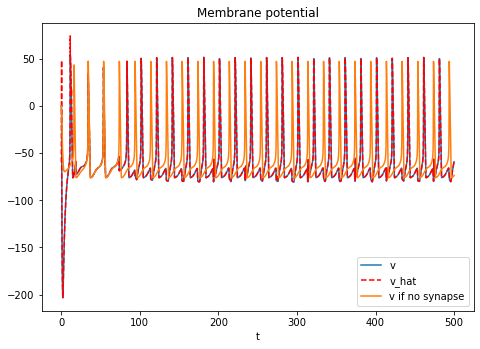

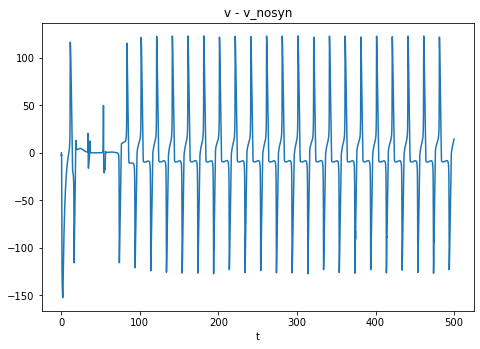

In [69]:
plt0 = plt.figure(); plt0ax = plt0.add_axes([0,0,1,1])
plt0ax.plot(t,v)
plt0ax.plot(t,v̂,color="red",linestyle="dashed")
plt0ax.plot(t,v_nosyn)
plt0ax.set_xlabel("t")
plt0ax.legend(["v", "v_hat", "v if no synapse"])
plt0ax.set_title("Membrane potential")

plt9 = plt.figure(); plt9ax = plt9.add_axes([0,0,1,1])
plt9ax.plot(t,v-v_nosyn)
plt9ax.set_xlabel("t")
plt9ax.set_title("v - v_nosyn")

Plotted below are the adaptive observer's estimates of the other parameters and the synaptic current.

Text(0.5, 1.0, 'I_syn (neglecting transient)')

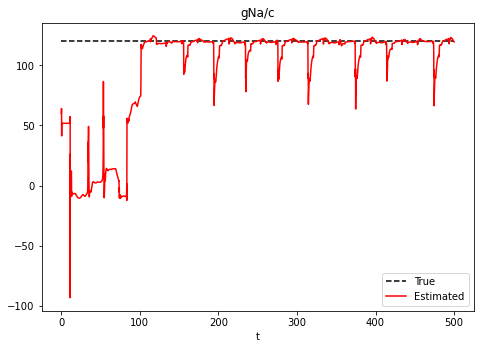

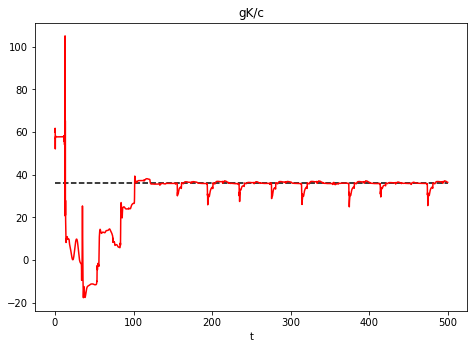

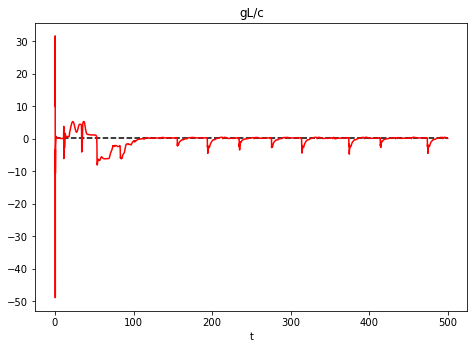

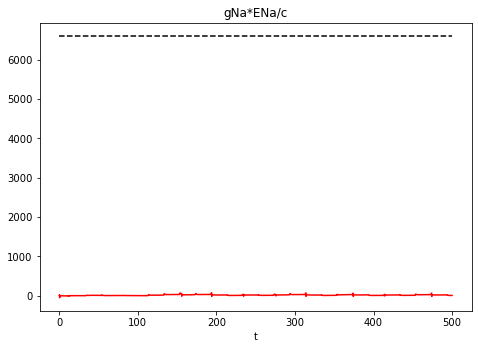

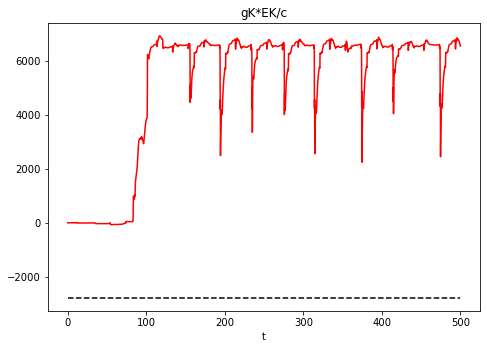

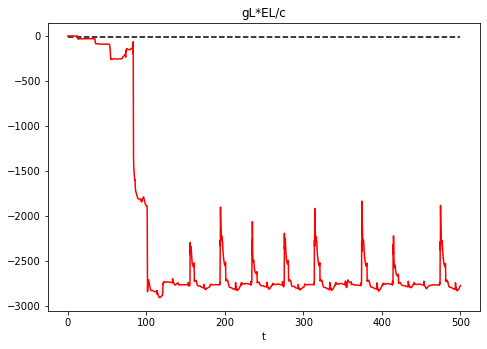

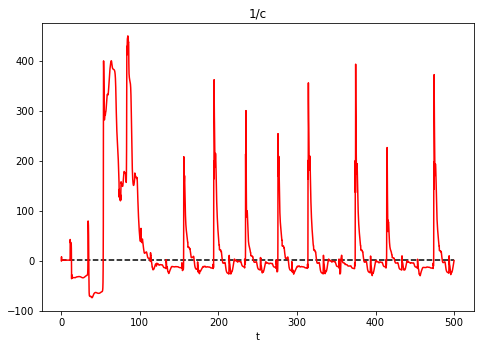

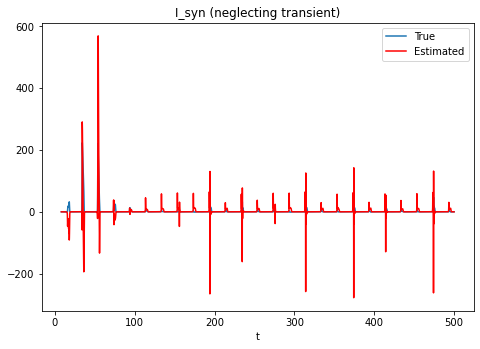

In [70]:
# Black dashed line is true value. Red is estimate.
# gNa/c
plt1 = plt.figure(); plt1ax = plt1.add_axes([0,0,1,1])
plt1ax.plot([0,Tfinal],[g[0]/c,g[0]/c],color="black",linestyle="dashed",label="gNa/c")
plt1ax.plot(t,θ̂[0,:],color="red")
plt1ax.set_xlabel("t")
plt1ax.legend(["True", "Estimated"])
plt1ax.set_title("gNa/c")

# gK/c
plt2 = plt.figure(); plt2ax = plt2.add_axes([0,0,1,1])
plt2ax.plot([0,Tfinal],[g[1]/c,g[1]/c],color="black",linestyle="dashed",label="gK/c")
plt2ax.set_xlabel("t")
plt2ax.plot(t,θ̂[1,:],color="red")
plt2ax.set_title("gK/c")

# gL/c
plt3 = plt.figure(); plt3ax = plt3.add_axes([0,0,1,1])
plt3ax.plot([0,Tfinal],[g[2]/c,g[2]/c],color="black",linestyle="dashed",label="gL/c")
plt3ax.set_xlabel("t")
plt3ax.plot(t,θ̂[2,:],color="red")
plt3ax.set_title("gL/c")

# gNa*ENa/c
plt4 = plt.figure(); plt4ax = plt4.add_axes([0,0,1,1])
plt4ax.plot([0,Tfinal],[g[0]*E[0]/c,g[0]*E[0]/c],color="black",linestyle="dashed",label="gNa*ENa/c")
plt4ax.set_xlabel("t")
plt4ax.plot(t,θ̂[3,:],color="red")
plt4ax.set_title("gNa*ENa/c")

# gK*EK/c
plt5 = plt.figure(); plt5ax = plt5.add_axes([0,0,1,1])
plt5ax.plot([0,Tfinal],[g[1]*E[1]/c,g[1]*E[1]/c],color="black",linestyle="dashed",label="gK*EK/c")
plt5ax.plot(t,θ̂[4,:],color="red")
plt5ax.set_xlabel("t")
plt5ax.set_title("gK*EK/c")

# gL*EL/c
plt6 = plt.figure(); plt6ax = plt6.add_axes([0,0,1,1])
plt6ax.plot([0,Tfinal],[g[2]*E[2]/c,g[2]*E[2]/c],color="black",linestyle="dashed",label="gL*EL/c")
plt6ax.plot(t,θ̂[5,:],color="red")
plt6ax.set_xlabel("t")
plt6ax.set_title("gL*EL/c")

# 1/c
plt7 = plt.figure(); plt7ax = plt7.add_axes([0,0,1,1])
plt7ax.plot([0,Tfinal],[1/c,1/c],color="black",linestyle="dashed",label="1/c")
plt7ax.plot(t,θ̂[6,:],color="red")
plt7ax.set_xlabel("t")
plt7ax.set_title("1/c")

# Synaptic current (ignoring initial transient)
plt8 = plt.figure(); plt8ax = plt8.add_axes([0,0,1,1])
plt8ax.plot(t[300:],Isyn[300:],label="I_syn")
plt8ax.plot(t[300:],Isyn_hat[300:],color="red")
plt8ax.set_xlabel("t")
plt8ax.legend(["True", "Estimated"])
plt8ax.set_title("I_syn (neglecting transient)")

Controller performance cannot be measured by comparing $v$ and $v_{nosyn}$ without first accounting for phase shift. The plot below overlays the two variables with a phase shift applied. The plot below that is simply a zoomed-in version.

In [ ]:
plt9 = plt.figure(); plt9ax = plt9.add_axes([0,0,1,1])
go_from = 3000
phase_shift = 400

t_trunc = t[go_from:-phase_shift]
v_trunc = v[go_from+phase_shift:]
v_nosyn_trunc = v_nosyn[go_from:-phase_shift]

plt9ax.plot(t_trunc,v_trunc)
plt9ax.plot(t_trunc,v_nosyn_trunc)
plt9ax.set_xlabel("t")
plt9ax.legend(["v (phase-shifted)", "v if no synapse"])
plt9ax.set_title("Membrane potential")

Text(0.5, 1.0, 'Membrane potential')

In [ ]:
plt10 = plt.figure(); plt10ax = plt10.add_axes([0,0,1,1])

zoom_idx = 10000

plt10ax.plot(t_trunc[:zoom_idx],v_trunc[:zoom_idx])
plt10ax.plot(t_trunc[:zoom_idx],v_nosyn_trunc[:zoom_idx])
plt10ax.set_xlabel("t")
plt10ax.legend(["v (phase-shifted)", "v if no synapse"])
plt10ax.set_title("Membrane potential (zoomed plot)")

In [ ]:
# Code to find phase shift. Can ignore.
#from scipy.signal import find_peaks
#v_trunc_peaks, _ = find_peaks(v_trunc, height=0)
#v_trunc_peaks

#diffs,_ = find_peaks(v_nosyn_trunc)
#np.diff(diffs)
#diffs